# Numpyro and Hamiltonian Monte Carlo

In this tutorial we will see how we to integrate our ∂Lux optical models with a Probablistic Programming Language (PPL) Numpyro. This allows us to run a subset of MCMC algorithms known as HMC, that take advantage of autodiff in order to infer the relationship between a large number of parameters.

In this example we will simulate a binary star through a simple optical system, and simultanesouly infer the parameters of the stars and the state of the optical system at the same time.

---

In [1]:
# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

# Core jax
import jax.numpy as np
import jax.random as jr

# PPL
import numpyro as npy
import numpyro.distributions as dist

# Optimisation
import zodiax as zdx

# Optics
import dLux as dl
import dLux.utils as dlu

# Plotting/visualisation
import matplotlib.pyplot as plt
import chainconsumer as cc

# Set global plotting parameters
%matplotlib inline
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'serif'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

<Figure size 640x480 with 0 Axes>

First we want to create our spectral object for our binary star source, and then create the binary star object

Next we define the optical system and detector, and combine then with the binary soure in order to create a telescope object that we will use to model all of these components simultaneously.

In [2]:
# Use the AlphaCen object for nice units
source = dl.models.toliman.AlphaCen()
source = source.set(['log_flux', 'separation'], [3.5, 0.1])

# Aperture properties
wf_npix = 128
aperture = dl.ApertureFactory(wf_npix)

# Aberration properties
radial_terms = [2, 3]
true_coeffs = 1e-9 * jr.normal(jr.PRNGKey(0), (7,))
aberrations = dl.AberrationFactory(wf_npix, radial_terms, true_coeffs)

# Psf properties
psf_npixels = 16
psf_pixel_scale = 0.03

# Cosntruct
diameter = 1
optics = dl.AngularOptics(diameter, aperture, psf_npixels, psf_pixel_scale,
    aberrations=aberrations)

# Construct Telescope
telescope = dl.Instrument(optics, (source,'source'))

Now lets create the fake data and examine it. Note that for Numpyro we will flatten our data to make it easier to interact with

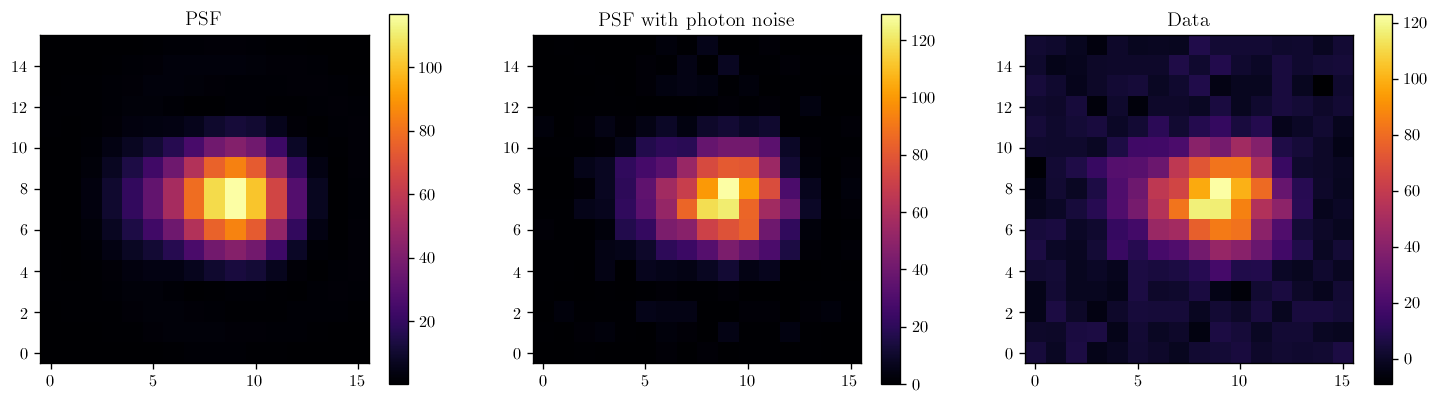

In [4]:
## Gerenate psf
psf = telescope.model()
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 3*jr.normal(jr.PRNGKey(0), psf_photon.shape)
data = psf_photon + bg_noise

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("PSF")
plt.imshow(psf)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("PSF with photon noise")
plt.imshow(psf_photon)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Data")
plt.imshow(data)
plt.colorbar()
plt.show()

---

# Inference with Numpyro

Awesome, now we are going to try and infer these parameters using an MCMC algortihm. There a few different parameters we want to learn:

##  Binary parameters
 - The (x,y) mean position (2 parameters)
 - The separation (1 parameter)
 - The position angle (1 parameter)
 - The mean flux (1 parameter)
 - The contrast ratio (1 parameter)
 
## Optical parameters
 - The zernike aberration coefficients (7 parameters)
 
## Detector parameters
 - The mean detector noise (1 parameter)
 
This gives us a total of 14 parameters, which is quite high dimensional for regular MCMC algortihms.

Now we construct our Numpyro sampling function. In this function we need to define priors distribution variables for our parameters, and feed them (along with the corresponsing path to that parameter in the model) into the .update_and_model() function. This allows for Numpyro to simulatensly sample the posterior for all of the parameters by taking advantage of the differentiable nature of these models. 

With these parameters we define a 'plate' which defines our data, using a Possion likelihood since this is our dominant noise source.

In [ ]:
parameters = ['x_position', 'y_position', 'separation', 'position_angle', 
    'log_flux', 'contrast']

def psf_model(data, model, path_dict=None):
    """
    Define the numpyro function
    """
    values = [
        npy.sample("x",        dist.Uniform(-0.1, 0.1)),
        npy.sample("y",        dist.Uniform(-0.1, 0.1)),
        npy.sample("r",        dist.Uniform(0.01, 0.5)),
        npy.sample("theta",    dist.Uniform(80, 100)),
        npy.sample("log_flux", dist.Uniform(3, 4)),
        npy.sample("contrast", dist.Uniform(1, 5)),
    ]

    with npy.plate("data", len(data.flatten())):
        poisson_model = dist.Poisson(
            model.set(parameters, values).model().flatten())
        return npy.sample("psf", poisson_model, obs=data.flatten())

Now we can use the numpyro.render_model() function to check to make sure everything is being fed in correctly

In [11]:
# npy.render_model(psf_model, model_args=(data, telescope))

Using the model above, we can now sample from the posterior distribution using the No U-Turn Sampler (NUTS).

In [12]:
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),    
    num_warmup=2000,
    num_samples=2000,
    num_chains=jax.device_count(),
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data, telescope)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 6min 45s, sys: 40.2 s, total: 7min 25s
Wall time: 1min 7s


Now we examine the summary - Note here we want to make sure that all of the r_hat values are ~1

In [13]:
sampler.print_summary()
values_out = sampler.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  contrast      2.46      0.24      2.45      2.06      2.84   3859.30      1.00
  log_flux      3.51      0.01      3.51      3.50      3.52   7020.82      1.00
         r      0.10      0.00      0.10      0.09      0.10   4008.66      1.00
     theta     87.17      1.67     87.16     84.32     89.87   4583.33      1.00
         x      0.01      0.00      0.01      0.00      0.01   3397.37      1.00
         y     -0.00      0.00     -0.00     -0.00      0.00   5139.15      1.00

Number of divergences: 0


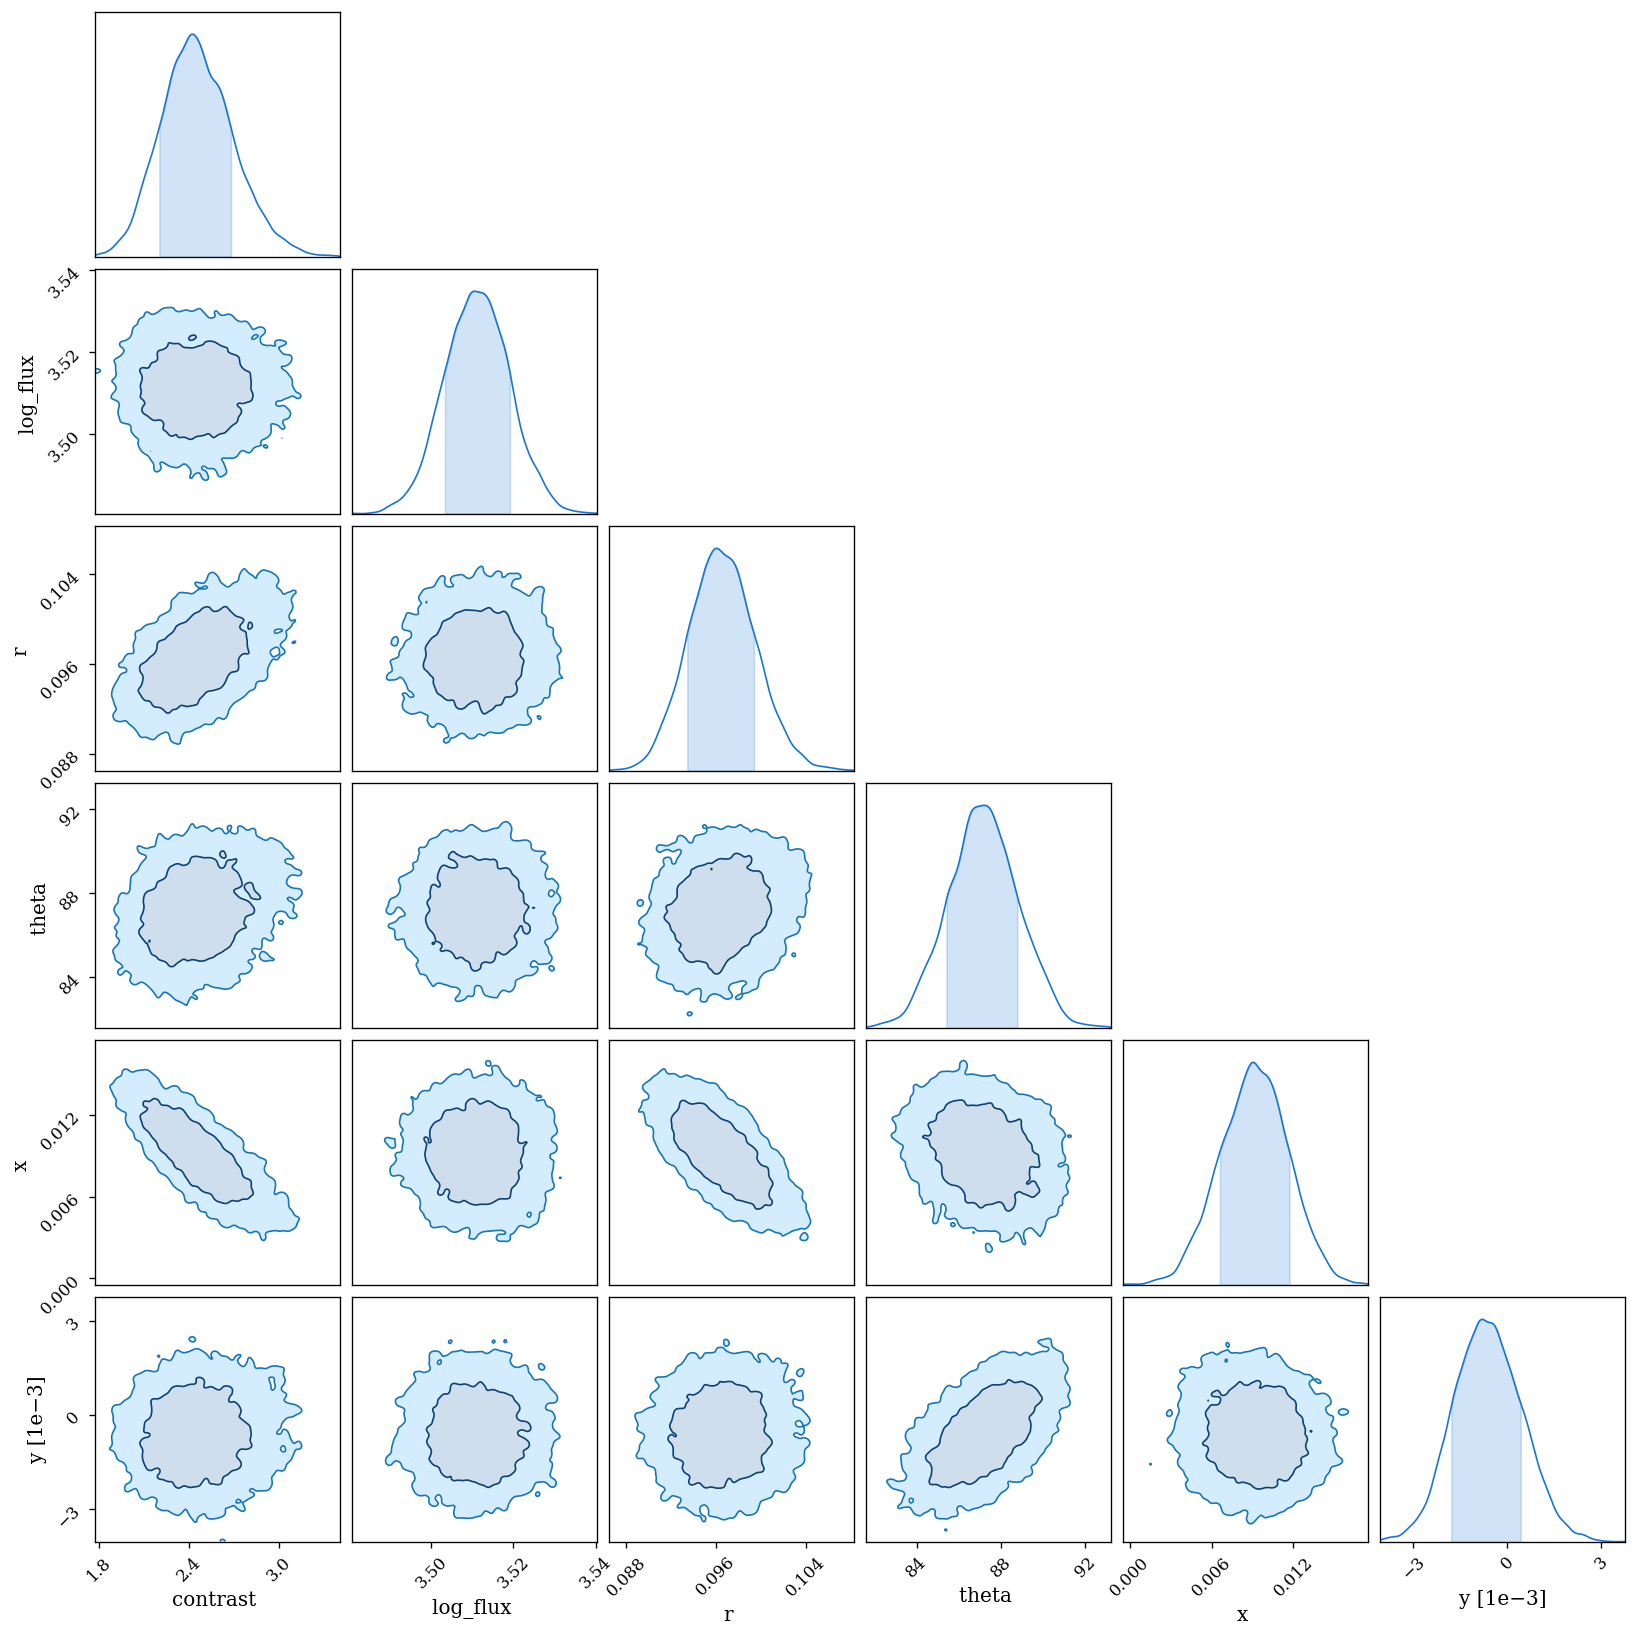

In [14]:
chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot()
fig.set_size_inches((15,15));

Excellent! As we can see all of the praameters are well constrained!